In [1]:
import numpy as np
import pandas as pd
import polars as pl

import requests
import time
import os
import json
import datetime

import seaborn as sns
from matplotlib import pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

/var/folders/38/x32ycmvj6zs1zqg8dn112ys40000gn/T/ipykernel_80092/3262277270.py:18: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


# Progetti OpenCoesione a tema ambiente

Usiamo i dati di [OpenCoesione](https://opencoesione.gov.it/it/) per fare delle analisi, aggregarli usarli per visualizzazioni.

Esiste un'API ma gli endpoint non sono ben documentati, bisogna giocarci un po' per capirne la struttura e dati di ritorno. Nella prima parte qui tireremo giù dei dati dall'API, nella seconda usiamo i CSV (spiegheremo perché). Nota: non è necessario registrare un account per accedere all'API ma se lo si fa si ha un rate limit più alto. Per i nostri scopi non serve, per ora.

I metadati con le descrizioni di ogni campo dei dati sono [qui](https://opencoesione.gov.it/media/opendata/metadati_progetti_tracciato_esteso.xlsx).

I dati che useremo sono gli ultimi disponibili - attualmente aggiornati a Febbraio 2024.

## Lista temi da API

Voglianmo concentrarci sui progetti a tema "Ambiente".

In [360]:
# i temi sono 11, in una sola pagina
r = requests.get(f"https://opencoesione.gov.it/it/api/temi/?format=json")

# vediamo tutti i nomi dei temi
[item['descrizione'] for item in r.json()['results']]

['Ricerca e innovazione',
 'Reti e servizi digitali',
 'Competitività delle imprese',
 'Energia',
 'Ambiente',
 'Cultura e turismo',
 'Trasporti e mobilità',
 'Occupazione e lavoro',
 'Inclusione sociale e salute',
 'Istruzione e formazione',
 'Capacità amministrativa']

## Dati di tutti i progetti a tema "Ambiente": via API

L'endpoint dei progetti pagina ogni 25. Senza account per accesso autorizzato puoi fare 12 requests/minuto, ovvero una ogni 5 secondi; con accesso autorizzato una al secondo.

Salviamo le responses (solo i risultati) su file indicizzati per pagina.

In [361]:
r = requests.get(f"https://opencoesione.gov.it/it/api/progetti/?format=json&tema=ambiente")

In [362]:
r
r.json()['count']   # totale progetti selezionati
r.json()['page_size']  # quanti per pagina
r.json()['count'] / r.json()['page_size']   # quindi quante pagine

<Response [200]>

24453

25

978.12

In [363]:
980*5/60 # minuti di presa dati attesi

81.66666666666667

In [154]:
# creiamo una cartella dove mettere i dati
os.makedirs('dati/progetti')

FileExistsError: [Errno 17] File exists: 'dati/progetti'

In [159]:
# prendo tutto come sta e metto in un dataframe, poi puliamo dopo

#df = pl.DataFrame(d['results']) # metto i risultati di pagina in un dataframe

# nota: potrei scrivere il CSV da polars invece, ma non mi conviene
# aggiungerei overhead e poi ho un problema con le colonne che sono liste

# iniziamo dalla prima pagina (non serve in query arg page, ma per essere espliciti)
r = requests.get(f"https://opencoesione.gov.it/it/api/progetti/?format=json&tema=ambiente&page=1")
d = r.json()
url = d['next']

page = 1   # inizia da dove vuoi - se il ciclo si e' bloccato puoi riprendere dalla pagina precedente
while d['next']:
#while page < 10:   # per testare
    print(page)    # tengo traccia visuale della pagina
    
    url = f"https://opencoesione.gov.it/it/api/progetti/?format=json&tema=ambiente&page={page}"
    
    r = requests.get(url)
    d = r.json()   # se mi throttlano si rompe qui
    
    json.dump(d['results'], open(f"dati/progetti/page_{page}.json", 'w'))
    
    #url = d['next']   # next url sta anche qui ma non ci serve
    
    page += 1
    
    time.sleep(6)   # per stare sicuri mettiamo in pausa per 6 secs (accesso non autorizzato)
    # con accesso autorizzato sarei piu' veloce

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [367]:
# construisco un dataframe con Polars
df = pl.DataFrame()
dir_ = 'dati/progetti/'
for filename in os.listdir(dir_):
    if '.ipynb' not in filename:
        df = pl.concat([df, pl.DataFrame(json.load(open(dir_ + filename)))]) 

## Guardiamo i dati e facciamo qualche sanity check

In [369]:
df.head(2)
df['cod_locale_progetto'].n_unique(), len(df)

url,cod_locale_progetto,cup,cup_descr_natura,oc_descr_ciclo,oc_finanz_tot_pub_netto,oc_stato_progetto,oc_tema_sintetico,oc_titolo_progetto,tot_pagamenti,percentuale_avanzamento,soggetti,territori
str,str,str,str,str,str,str,str,str,str,str,list[struct[2]],list[str]
"""https://opencoesione.gov.it/it…","""1MISECAMGTSU11-BN01""","""I29H14000010002""","""REALIZZAZIONE DI LAVORI PUBBLI…","""Ciclo di programmazione 2000-2…","""4031109,09""","""In corso""","""Ambiente""","""LA PORTA DEL SANNIO. MESSA IN …","""604666,37""","""15%""","[{""REGIONE CAMPANIA"",[""Programmatore"", ""Attuatore"", ""Beneficiario""]}]","[""faicchio-comune""]"
"""https://opencoesione.gov.it/it…","""1CA53C52007IT161PO009""","""I63J13000160002""","""REALIZZAZIONE DI LAVORI PUBBLI…","""Ciclo di programmazione 2007-2…","""4024146,43""","""Liquidato""","""Ambiente""","""BONIFICA DISCARICA COMUNALE LO…","""4022836,32""","""99%""","[{""REGIONE CAMPANIA"",[""Programmatore""]}, {""COMUNE DI SARNO"",[""Attuatore"", ""Beneficiario""]}]","[""sarno-comune""]"


(24453, 24453)

In [370]:
df.columns

['url',
 'cod_locale_progetto',
 'cup',
 'cup_descr_natura',
 'oc_descr_ciclo',
 'oc_finanz_tot_pub_netto',
 'oc_stato_progetto',
 'oc_tema_sintetico',
 'oc_titolo_progetto',
 'tot_pagamenti',
 'percentuale_avanzamento',
 'soggetti',
 'territori']

## Ripulitura dati

In [230]:
# trasformo stringhe in dati numerici quando serve - per alcuni devi cambiare il formato
df = df.with_columns(pl.col(["oc_finanz_tot_pub_netto"]).str.replace_all(',', '.'))
df = df.with_columns(oc_finanz_tot_pub_netto=pl.col("oc_finanz_tot_pub_netto").str.to_decimal())

df = df.with_columns(pl.col(["tot_pagamenti"]).str.replace_all(',', '.'))
df = df.with_columns(tot_pagamenti=pl.col("tot_pagamenti").str.to_decimal())

df = df.with_columns(pl.col(["percentuale_avanzamento"]).str.replace_all('%', ''))
df = df.with_columns(percentuale_avanzamento=pl.col("percentuale_avanzamento").str.to_integer())

# cose cosmetiche per comodita'
df = df.with_columns(pl.col(["oc_descr_ciclo"]).str.replace_all('Ciclo di programmazione ', ''))
df = df.with_columns(pl.col(["oc_descr_ciclo"]).str.replace_all('\"', ''))

## Prendiamo i dati CSV invece

Visto che dall'endpoint progetti non si ottengono direttamente tutti i campi utili al nostro scopo, dovremmo fare delle requests incrociate. I CSV sono completi di tutti i dati utili e direttamente presenti (ovviamente) in forma tabulare. 

In [2]:
# prendiamo quelli del ciclo scorso - qui per comodità usiamo Pandas
df = pd.read_csv('/Users/martina/Downloads/progetti_esteso_AMBIENTE_2014-2020_20240229.csv', 
                 sep=';')

/var/folders/38/x32ycmvj6zs1zqg8dn112ys40000gn/T/ipykernel_80092/3436799693.py:2: DtypeWarning: Columns (45,56,57,58,59,64,66,68,70,72,78,79,80,81,86,88,90,92,98,153) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/martina/Downloads/progetti_esteso_AMBIENTE_2014-2020_20240229.csv',


In [455]:
len(df)

9134

## Di nuovo controlli e ripulitura

In [456]:
df.head(2)
#df.dtypes.iloc[110:120]
#df['OC_DATA_FINE_PROGETTO_PREVISTA']

df['COD_LOCALE_PROGETTO'].nunique(), df['CUP'].nunique()  # controlla n. progetti unici - non so perche' sono diversi 
len(df[(df.OC_DATA_FINE_PROGETTO_PREVISTA.isna()) | 
       (df.OC_DATA_FINE_PROGETTO_PREVISTA=='')])  # sanity check quelli senza data prevista - ?

df['OC_DATA_FINE_PROGETTO_EFFETTIVA'].max()  # ci sono date effettive nel futuro? 

,COD_LOCALE_PROGETTO,CUP,OC_TITOLO_PROGETTO,OC_SINTESI_PROGETTO,OC_LINK,OC_COD_CICLO,OC_DESCR_CICLO,OC_COD_TEMA_SINTETICO,OC_TEMA_SINTETICO,COD_GRANDE_PROGETTO,DESCRIZIONE_GRANDE_PROGETTO,OC_COD_FONTE,OC_DESCR_FONTE,FONDO_COMUNITARIO,OC_CODICE_PROGRAMMA,OC_DESCRIZIONE_PROGRAMMA,COD_OB_TEMATICO,DESCR_OB_TEMATICO,COD_PRIORITA_INVEST,DESCR_PRIORITA_INVEST,OC_COD_CATEGORIA_SPESA,OC_DESCR_CATEGORIA_SPESA,OC_ARTICOLAZIONE_PROGRAMMA,OC_SUBARTICOLAZIONE_PROGRAMMA,OC_COD_ARTICOLAZ_PROGRAMMA,OC_DESCR_ARTICOLAZ_PROGRAMMA,OC_COD_SUBARTICOLAZ_PROGRAMMA,OC_DESCR_SUBARTICOLAZ_PROGRAMMA,COD_STRUMENTO,DESCR_STRUMENTO,DESCR_TIPO_STRUMENTO,CUP_COD_NATURA,CUP_DESCR_NATURA,CUP_COD_TIPOLOGIA,CUP_DESCR_TIPOLOGIA,CUP_COD_SETTORE,CUP_DESCR_SETTORE,CUP_COD_SOTTOSETTORE,CUP_DESCR_SOTTOSETTORE,CUP_COD_CATEGORIA,CUP_DESCR_CATEGORIA,COD_ATECO,DESCRIZIONE_ATECO,OC_COD_TIPO_AIUTO,OC_DESCR_TIPO_AIUTO,COD_REGIONE,DEN_REGIONE,COD_PROVINCIA,DEN_PROVINCIA,COD_COMUNE,DEN_COMUNE,OC_MACROAREA,OC_COD_SLL,OC_DENOMINAZIONE_SLL,FINANZ_UE,FINANZ_UE_FESR,FINANZ_UE_FSE,FINANZ_UE_FEASR,FINANZ_UE_FEAMP,FINANZ_UE_IOG,FINANZ_STATO_FONDO_DI_ROTAZIONE,FINANZ_STATO_FSC,FINANZ_STATO_PAC,FINANZ_STATO_COMPLETAMENTI,FINANZ_STATO_ALTRI_PROVVEDIMENTI,FINANZ_REGIONE,FINANZ_PROVINCIA,FINANZ_COMUNE,FINANZ_RISORSE_LIBERATE,FINANZ_ALTRO_PUBBLICO,FINANZ_STATO_ESTERO,FINANZ_PRIVATO,FINANZ_DA_REPERIRE,FINANZ_TOTALE_PUBBLICO,ECONOMIE_TOTALI,ECONOMIE_TOTALI_PUBBLICHE,OC_FINANZ_UE_NETTO,OC_FINANZ_UE_FESR_NETTO,OC_FINANZ_UE_FSE_NETTO,OC_FINANZ_UE_FEASR_NETTO,OC_FINANZ_UE_FEAMP_NETTO,OC_FINANZ_UE_IOG_NETTO,OC_FINANZ_STATO_FONDO_ROT_NETTO,OC_FINANZ_STATO_FSC_NETTO,OC_FINANZ_STATO_PAC_NETTO,OC_FINANZ_STATO_COMPL_NETTO,OC_FINANZ_STATO_ALTRI_PROV_NETTO,OC_FINANZ_REGIONE_NETTO,OC_FINANZ_PROVINCIA_NETTO,OC_FINANZ_COMUNE_NETTO,OC_FINANZ_RISORSE_LIBERATE_NETTO,OC_FINANZ_ALTRO_PUBBLICO_NETTO,OC_FINANZ_STATO_ESTERO_NETTO,OC_FINANZ_PRIVATO_NETTO,OC_FINANZ_TOT_PUB_NETTO,OC_COSTO_COESIONE,IMPEGNI,OC_IMPEGNI_GIURID_VINCOLANTI,OC_IMPEGNI_TRASFERIMENTI,OC_IMPEGNI_COESIONE,TOT_PAGAMENTI,OC_TOT_PAGAMENTI_BENEFICIARI,OC_TOT_PAGAMENTI_TRASFERIMENTI,COSTO_REALIZZATO,COSTO_RENDICONTABILE_UE,OC_TOT_PAGAMENTI_RENDICONTAB_UE,OC_TOT_PAGAMENTI_FSC,OC_TOT_PAGAMENTI_PAC,OC_PAGAMENTI_COESIONE,OC_DATA_INIZIO_PROGETTO,OC_DATA_FINE_PROGETTO_PREVISTA,OC_DATA_FINE_PROGETTO_EFFETTIVA,DATA_INIZIO_PREV_STUDIO_FATT,DATA_INIZIO_EFF_STUDIO_FATT,DATA_FINE_PREV_STUDIO_FATT,DATA_FINE_EFF_STUDIO_FATT,DATA_INIZIO_PREV_PROG_PREL,DATA_INIZIO_EFF_PROG_PREL,DATA_FINE_PREV_PROG_PREL,DATA_FINE_EFF_PROG_PREL,DATA_INIZIO_PREV_PROG_DEF,DATA_INIZIO_EFF_PROG_DEF,DATA_FINE_PREV_PROG_DEF,DATA_FINE_EFF_PROG_DEF,DATA_INIZIO_PREV_PROG_ESEC,DATA_INIZIO_EFF_PROG_ESEC,DATA_FINE_PREV_PROG_ESEC,DATA_FINE_EFF_PROG_ESEC,DATA_INIZIO_PREV_AGG_BANDO,DATA_INIZIO_EFF_AGG_BANDO,DATA_FINE_PREV_AGG_BANDO,DATA_FINE_EFF_AGG_BANDO,DATA_INIZIO_PREV_STIP_ATTRIB,DATA_INIZIO_EFF_STIP_ATTRIB,DATA_FINE_PREV_STIP_ATTRIB,DATA_FINE_EFF_STIP_ATTRIB,DATA_INIZIO_PREV_ESECUZIONE,DATA_INIZIO_EFF_ESECUZIONE,DATA_FINE_PREV_ESECUZIONE,DATA_FINE_EFF_ESECUZIONE,DATA_INIZIO_PREV_COLLAUDO,DATA_INIZIO_EFF_COLLAUDO,DATA_FINE_PREV_COLLAUDO,DATA_FINE_EFF_COLLAUDO,OC_STATO_FINANZIARIO,OC_STATO_PROGETTO,OC_STATO_PROCEDURALE,OC_COD_FASE_CORRENTE,OC_DESCR_FASE_CORRENTE,COD_PROCED_ATTIVAZIONE,DESCR_PROCED_ATTIVAZIONE,COD_TIPO_PROCED_ATTIVAZIONE,DESCR_TIPO_PROCED_ATTIVAZIONE,OC_CODFISC_PROGRAMMATORE,OC_DENOM_PROGRAMMATORE,OC_COD_FORMA_GIU_PROGRAMMATORE,OC_DESCR_FORMA_GIU_PROGRAMMATORE,OC_TOTALE_PROGRAMMATORI,OC_CODFISC_ATTUATORE,OC_DENOM_ATTUATORE,OC_COD_FORMA_GIU_ATTUATORE,OC_DESCR_FORMA_GIU_ATTUATORE,OC_TOTALE_ATTUATORI,OC_CODFISC_BENEFICIARIO,OC_DENOM_BENEFICIARIO,OC_COD_FORMA_GIU_BENEFICIARIO,OC_DESCR_FORMA_GIU_BENEFICIARIO,OC_TOTALE_BENEFICIARI,OC_CODFISC_REALIZZATORE,OC_DENOM_REALIZZATORE,OC_COD_FORMA_GIU_REALIZZATORE,OC_DESCR_FORMA_GIU_REALIZZATORE,OC_TOTALE_REALIZZATORI,OC_TOTALE_INDICATORI,COD_INDICATORE_1,DESCR_INDICATORE_1,UNITA_MISURA_INDICATORE_1,PROGRAMMATO_INDICATORE_1,REALIZZATO_INDICATORE_1

(9134, 8758)

0

20271231.0

In [457]:
# cambiamo formato date a datetime - per quelle principali/che ci servono

df['OC_DATA_FINE_PROGETTO_PREVISTA'] = pd.to_datetime(df['OC_DATA_FINE_PROGETTO_PREVISTA'], format='%Y%m%d', )
df['OC_DATA_FINE_PROGETTO_EFFETTIVA'] = pd.to_datetime(df['OC_DATA_FINE_PROGETTO_EFFETTIVA'], format='%Y%m%d')

# tempo trascorso (in giorni) tra le due date
df['OC_FINE_days'] = (df['OC_DATA_FINE_PROGETTO_EFFETTIVA'] - df['OC_DATA_FINE_PROGETTO_PREVISTA']).dt.days

In [458]:
# conta quanti in tot hanno data effettiva di conclusione nel futuro
# nel futuro rispetto alla data di aggiornamento del CSV (dal filename)

df_tmp_over = df[df.OC_DATA_FINE_PROGETTO_EFFETTIVA > datetime.datetime(2024,2,29)] \
    [['OC_TITOLO_PROGETTO', 'OC_FINE_days', 'DEN_REGIONE', 'OC_STATO_PROGETTO']+ 
     [item for item in df.columns if 'DATA_' in item]]

len(df_tmp_over)
len(df_tmp_over[(df_tmp_over.DEN_REGIONE=='CAMPANIA') & (df_tmp_over.OC_STATO_PROGETTO=='Concluso')])
# df_tmp_over


# sembra che le date (prevista/effettiva) coincidano per questi, quindi presumibilmente sono placeholder
# alcuni sono conclusi pero', per questi magari la data e' errata?
# comunque sono solo ~30/40, conviene ignorarli 

34

2

## Analisi e prima visualizzazione: ritardi di completamento

Visualizzaremo, per i progetti completati oltre la data prevista, la distribuzione, regione per regione, dei ritardi. Questo per i dati dell'ultimo ciclo concluso.

In [459]:
set(df['OC_STATO_PROGETTO'])  # controlla i metadati per le definizioni 

{'Concluso', 'In corso', 'Liquidato', 'Non avviato'}

### Conteggi per regione 

Possiamo controllare sulla piattaforma come double-check per essere certi di non fare errori. Per es [qui](https://opencoesione.gov.it/it/dati/temi/ambiente/?ciclo_programmazione=2) vediamo i conteggi di progetti per regione su tema ambiente (seleziona "regione" nella mappa). Nota: la mappa non esclude i progetti multi-regione che noi abbiamo escluso, quindi i nostri conteggi possono apparire leggermente più bassi.

In [471]:
# per regione: tot e conclusi
# conclusi entro la data prevista
# conclusi prima della data prevista

# togli quelli non per regione
# per i conclusi, togli quelli con data di conclusione prevista superiore a data aggiornamento file

dt_aggiorn = datetime.datetime(2024,2,29)  # data aggiornamento dati

# li contiamo per CUP
# quelli "conclusi" nel futuro sono pochi, si possono togliere

# escludiamo quelli riferiti a enti non regione (nazione e gruppi di regioni)
df_tmp = df[(~df.DEN_REGIONE.str.contains('::'))]

df_agg = df_tmp.groupby('DEN_REGIONE').agg(
    
            # progetti totali
            n=('CUP', 'size'), 
    
            # progetti conclusi  
            n_conclusi=(
                'CUP', 
                lambda x: ((df.loc[x.index, 'OC_STATO_PROGETTO'] == 'Concluso') & 
                           (df.loc[x.index, 'OC_DATA_FINE_PROGETTO_EFFETTIVA'] <= dt_aggiorn)).sum()),    

            # conclusi entro data prevista
            n_conclusi_entro=(
                'CUP', 
                lambda x: ((df.loc[x.index, 'OC_STATO_PROGETTO'] == 'Concluso') & 
                           (df.loc[x.index, 'OC_FINE_days'] <= 0) & 
                           (df.loc[x.index, 'OC_DATA_FINE_PROGETTO_EFFETTIVA'] <= dt_aggiorn)).sum()),
    
            # conclusi prima della data prevista 
            n_conclusi_prima=(
                'CUP', 
                lambda x: ((df.loc[x.index, 'OC_STATO_PROGETTO'] == 'Concluso') & 
                           (df.loc[x.index, 'OC_FINE_days'] < 0) & 
                           (df.loc[x.index, 'OC_DATA_FINE_PROGETTO_EFFETTIVA'] <= dt_aggiorn)).sum()),

            # conclusi dopo data prevista
            n_conclusi_dopo=(
                'CUP', 
                lambda x: ((df.loc[x.index, 'OC_STATO_PROGETTO'] == 'Concluso') & 
                           (df.loc[x.index, 'OC_FINE_days'] > 0) & 
                           (df.loc[x.index, 'OC_DATA_FINE_PROGETTO_EFFETTIVA'] <= dt_aggiorn)).sum()),     

).reset_index()

# proporzioni 
df_agg['f_conclusi'] = round(df_agg['n_conclusi']/df_agg['n'], 2)
df_agg['f_conclusi_entro'] = round(df_agg['n_conclusi_entro']/df_agg['n'], 2)

# guardiamo i conteggi ordinando per 
df_agg.sort_values('f_conclusi', ascending=False)

,DEN_REGIONE,n,n_conclusi,n_conclusi_entro,n_conclusi_prima,n_conclusi_dopo,f_conclusi,f_conclusi_entro
19,TRENTINO-ALTO ADIGE,157,93,43,42,50,0.59,0.27
22,VENETO,134,55,13,11,42,0.41,0.10
8,LIGURIA,74,24,22,18,2,0.32,0.30
9,LOMBARDIA,137,42,26,20,16,0.31,0.19
4,CAMPANIA,1718,474,416,172,58,0.28,0.24
17,SICILIA,1589,428,412,36,16,0.27,0.26
20,UMBRIA,131,34,32,23,2,0.26,0.24
10,MARCHE,131,31,21,20,10,0.24,0.16
14,PIEMONTE,225,47,29,22,18,0.21,0.13
16,SARDEGNA,544,115,78,49,37,0.21,0.14


In [461]:
# sanity checks 
# np.median(df[(df.DEN_REGIONE=='UMBRIA')& 
#            (df.OC_STATO_PROGETTO=='Concluso') & 
#            (df.OC_FINE_days > 30)]['OC_FINE_days'])

len(df[df.DEN_REGIONE=='VENETO']), len(df[df.DEN_REGIONE.str.contains('VENETO')])  # la UI mostra i secondi 
# noi facciamo solo quelli di singola regione invece 

# df[(df.DEN_REGIONE=='LIGURIA') & 
#    (~df.OC_FINE_days.isna())
#   ].sort_values('OC_FINE_days')[['OC_TITOLO_PROGETTO', 'OC_FINE_days']+ 
#                                 [item for item in df.columns if 'DATA_' in item]].tail()

#df.sort_values('OC_DATA_FINE_PROGETTO_PREVISTA', ascending=False)
 # [[item for item in df.columns if 'DATA_' in item]]


(134, 168)

### Vizzin'

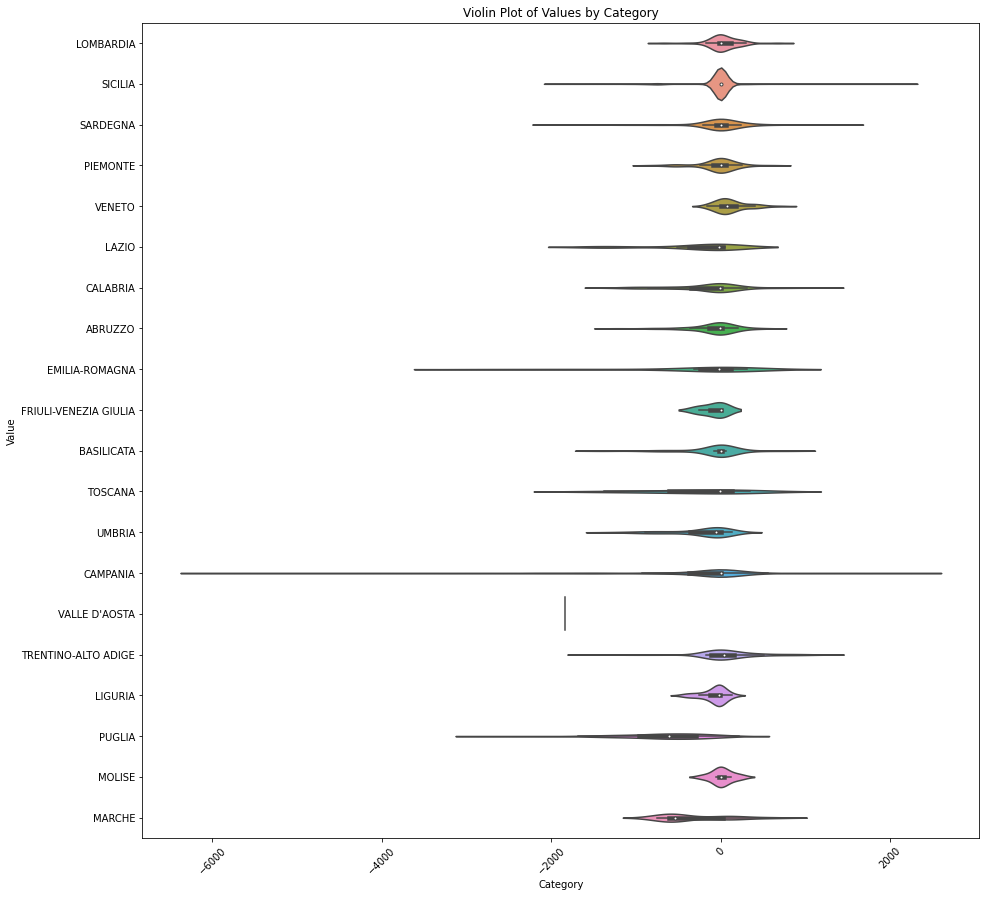

In [462]:
# Violin plot del numero di giorni tra data prevista ed effettiva per regione

plt.figure(figsize=(15, 15))

df_tmp = df[~df.DEN_REGIONE.str.contains('::')]

sns.violinplot(y='DEN_REGIONE', x='OC_FINE_days', 
               data=df_tmp[df_tmp.OC_STATO_PROGETTO=='Concluso'],
              );
plt.title('Violin Plot of Values by Category');
plt.xlabel('Category');
plt.ylabel('Value');

plt.xticks(rotation=45);
plt.show();

# nota: ci sono questi -6000 perche' 
# ci sono progetti conclusi con data fine prevista nel 2025 ma anche 2028/29 (hanno fatto molto prima)!

In [463]:
len(df)

9134

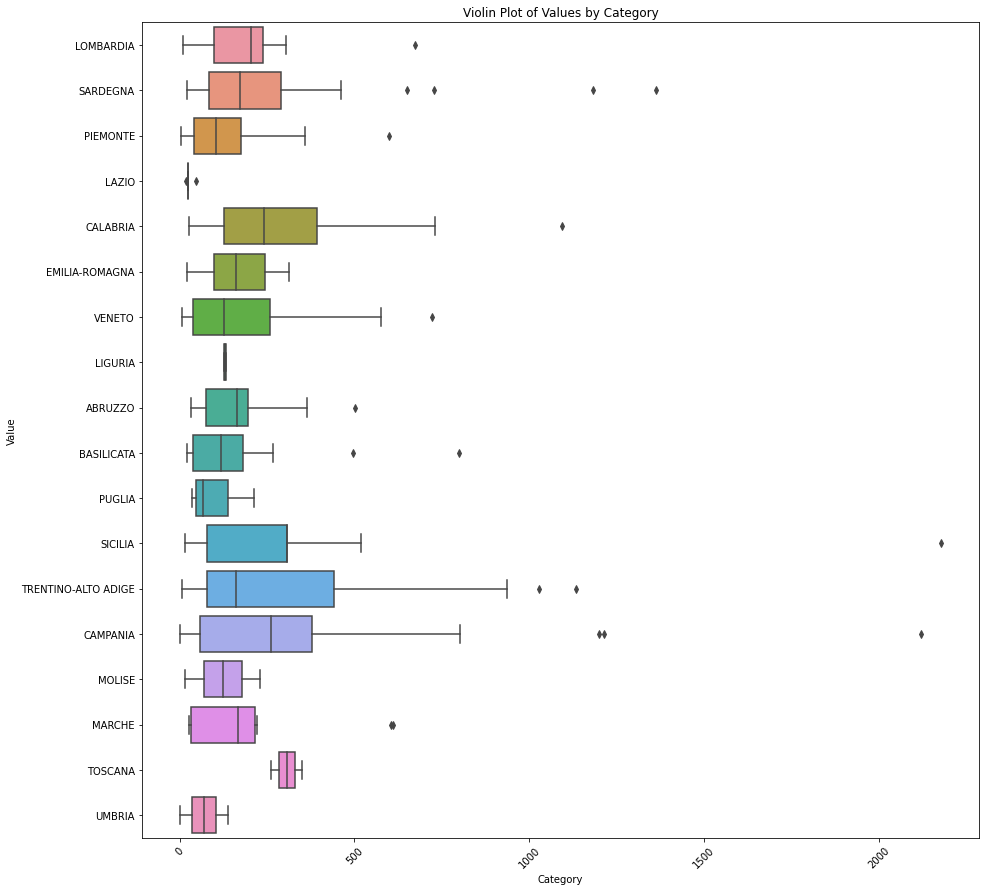

In [464]:
# e se faccio solo quelli conclusi NON prima? 
# facciamoli anche in box plot che si vede meglio

plt.figure(figsize=(15, 15))
# togliamo quelli dopo il timestamp di quando il file e' stato fatto (aggiornamento file)
df_tmp = df[(~df.DEN_REGIONE.str.contains('::')) & 
            (df.OC_FINE_days > 0) &
             (df.OC_DATA_FINE_PROGETTO_EFFETTIVA <= dt_aggiorn) & 
            (df.OC_STATO_PROGETTO=='Concluso')
            ]

sns.boxplot(y='DEN_REGIONE', x='OC_FINE_days', 
               data=df_tmp
              );
plt.title('Violin Plot of Values by Category');
plt.xlabel('Category');
plt.ylabel('Value');

plt.xticks(rotation=45);
plt.show();

### Qualche check/approfondimento

In [468]:
#set(df['DEN_REGIONE'])
df[(df.DEN_REGIONE=="VALLE D'AOSTA") & 
       (df.OC_STATO_PROGETTO=='Concluso')
      ]['OC_FINE_days']

2160   -1840.0
Name: OC_FINE_days, dtype: float64

In [469]:
r = 'V'

# df_tmp[df_tmp.DEN_REGIONE==r][['OC_TITOLO_PROGETTO', 
#                                         'OC_DATA_FINE_PROGETTO_PREVISTA',
#                                         'OC_DATA_FINE_PROGETTO_EFFETTIVA',
#                                         'OC_FINE_days'
#                                        ]]

df_tmp[df_tmp.DEN_REGIONE==r]['OC_FINE_days'].min(), df_tmp[df_tmp.DEN_REGIONE==r]['OC_FINE_days'].max()
df_tmp[df_tmp.DEN_REGIONE==r]['OC_FINE_days'].median()

(nan, nan)

nan

In [470]:
# per regione, media della diff in days, e altre stats 

df_tmp.groupby('DEN_REGIONE').agg({'COD_LOCALE_PROGETTO': 'count', 
                                   'OC_FINE_days': ['mean', 'std', 'median', 
                                                    'min', 'max', 
                                                   ]})

COD_LOCALE_PROGETTO OC_FINE_days                     \
                                  count         mean         std median   
DEN_REGIONE                                                               
ABRUZZO              12                  175.750000   137.391362  165.0   
BASILICATA           13                  182.153846   228.071205  118.0   
CALABRIA             16                  324.000000   303.644309  242.5   
CAMPANIA             58                  317.706897   362.494574  260.5   
EMILIA-ROMAGNA       9                   173.000000   101.982842  162.0   
LAZIO                7                   25.714286    9.569296    23.0    
LIGURIA              2                   129.500000   4.949747    129.5   
LOMBARDIA            16                  192.625000   157.319579  205.0   
MARCHE               10                  210.100000   223.123508  168.0   
MOLISE               3                   123.333333   108.509600  125.0   
PIEMONTE             18                  143.388889   149.483479  104.5   
PUGLIA               8                   97.250000    68.430883   67.5    
SARDEGNA             37                  260.729730   296.770174  174.0   
SICILIA              16                  349.687500   510.515650  306.0   
TOSCANA              2                   306.500000   62.932504   306.5   
TRENTINO-ALTO ADIGE  50                  297.240000   299.021572  161.5   
UMBRIA               2                   69.000000    96.166522   69.0    
VENETO               42                  180.119048   175.242439  127.5   

                                    
                       min     max  
DEN_REGIONE                         
ABRUZZO              33.0   501.0   
BASILICATA           20.0   800.0   
CALABRIA             28.0   1095.0  
CAMPANIA             1.0    2122.0  
EMILIA-ROMAGNA       21.0   314.0   
LAZIO                18.0   47.0    
LIGURIA              126.0  133.0   
LOMBARDIA            11.0   673.0   
MARCHE               28.0   611.0   
MOLISE               14.0   231.0   
PIEMONTE             3.0    599.0   
PUGLIA               35.0   214.0   
SARDEGNA             20.0   1362.0  
SICILIA              16.0   2178.0  
TOSCANA              262.0  351.0   
TRENTINO-ALTO ADIGE  8.0    1135.0  
UMBRIA               1.0    137.0   
VENETO               8.0    722.0

In [472]:
#df_tmp[df_tmp.DEN_REGIONE=='LAZIO']

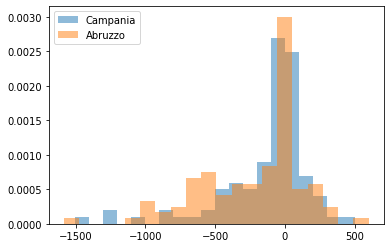

In [473]:
# istogramma dele differenze in giorni per alcune regioni
plt.hist(df_tmp[df_tmp['DEN_REGIONE']=='ABRUZZO']['OC_FINE_days'], 
         bins=20, alpha=0.5, density=True, label='Campania');
plt.hist(df_tmp[df_tmp['DEN_REGIONE']=='PIEMONTE']['OC_FINE_days'], 
         bins=20, density=True, alpha=0.5, label='Abruzzo');

plt.legend();

## Altro/temporaneo

Ignora la parte qui sotto, lavoro temporaneo o per successive analisi/viz

In [232]:
# # Set the color palette
# sns.set_palette("pastel")

# # Create a pivot table to align the data for stacked plotting
# df_tmp = df.group_by(['oc_descr_ciclo', 'oc_stato_progetto']).count()

# # Plot
# ax = df_tmp.plot(kind='bar', stacked=True)

# # Set labels and title
# ax.set_xlabel("Category")
# ax.set_ylabel("Value")
# ax.set_title("Stacked Bar Plot")

# # Show the plot
# plt.show()


In [235]:
df_tmp = df.group_by(['oc_descr_ciclo', 'oc_stato_progetto']).len()

df_tmp

oc_descr_ciclo,oc_stato_progetto,len
str,str,u32
"""2007-2013""","""Liquidato""",526
"""2021-2027""","""Concluso""",2
"""2021-2027""","""In corso""",153
"""2007-2013""","""In corso""",3160
"""2021-2027""","""Non avviato""",98
…,…,…
"""2014-2020""","""Concluso""",1772
"""2000-2006""","""Non avviato""",14
"""2000-2006""","""Liquidato""",14


In [249]:
df_tmp.filter(pl.col("oc_descr_ciclo") == '2007-2013')

df_tmp.filter((pl.col("oc_descr_ciclo") == '2007-2013') & 
              (pl.col("oc_stato_progetto") == 'Liquidato'))[0, 'len']

oc_descr_ciclo,oc_stato_progetto,len
str,str,u32
"""2007-2013""","""Non avviato""",187
"""2007-2013""","""Concluso""",7224
"""2007-2013""","""Liquidato""",526
"""2007-2013""","""In corso""",3160


526

In [4]:
# # bar plot lo devo fare cosi perche Polars df.plot non mi funziona a causa di una dependenciy, dice

# df_tmp = df.group_by(['oc_descr_ciclo', 'oc_stato_progetto']).len()

# # Sample data
# categories = ['2007-2013', '2014-2020', '2000-2006']
# subcategory1 = [df_tmp.filter((pl.col("oc_descr_ciclo") == '2000-2006') & 
#                               (pl.col("oc_stato_progetto") == 'Non avviato'))[0, 'len'],
#                 df_tmp.filter((pl.col("oc_descr_ciclo") == '2000-2006') & 
#                               (pl.col("oc_stato_progetto") == 'Liquidato'))[0, 'len'],
#                 df_tmp.filter((pl.col("oc_descr_ciclo") == '2000-2006') & 
#                               (pl.col("oc_stato_progetto") == 'Concluso'))[0, 'len'],
#                 ]
# subcategory2 = [df_tmp.filter((pl.col("oc_descr_ciclo") == '2007-2013') & 
#                               (pl.col("oc_stato_progetto") == 'Non avviato'))[0, 'len'],
#                 df_tmp.filter((pl.col("oc_descr_ciclo") == '2007-2013') & 
#                               (pl.col("oc_stato_progetto") == 'Liquidato'))[0, 'len'],
#                 df_tmp.filter((pl.col("oc_descr_ciclo") == '2007-2013') & 
#                               (pl.col("oc_stato_progetto") == 'Concluso'))[0, 'len'],
#                 ]
# subcategory3 = [df_tmp.filter((pl.col("oc_descr_ciclo") == '2014-2020') & 
#                               (pl.col("oc_stato_progetto") == 'Non avviato'))[0, 'len'],
#                 df_tmp.filter((pl.col("oc_descr_ciclo") == '2014-2020') & 
#                               (pl.col("oc_stato_progetto") == 'Liquidato'))[0, 'len'],
#                 df_tmp.filter((pl.col("oc_descr_ciclo") == '2014-2020') & 
#                               (pl.col("oc_stato_progetto") == 'Concluso'))[0, 'len'],
#                 ]

# data = {
#     'Liquidato': subcategory1,
#     'Non avviato': subcategory2,
#     'Concluso': subcategory3
# }

# # Set the color palette
# colors = ['#FF9999', '#66B2FF', '#99FF99', '#77FF99']

# # Define the position of the bars on the x-axis
# x = np.arange(len(categories))

# # Initialize the bottom position for stacking
# bottom = np.zeros(len(categories))

# # Plot each subcategory
# for i, (key, values) in enumerate(data.items()):
#     plt.bar(x, values, bottom=bottom, color=colors[i], label=key)
#     bottom += np.array(values)

# # Add labels and title
# plt.xlabel("Category");
# plt.ylabel("Value");
# plt.title("Stacked Bar Plot");
# plt.xticks(x, categories);
# plt.legend();

# # Show the plot
# plt.show();

In [3]:
# note: cannot pass to pandas, requires pyarrow but installing it crashed the kernel

## CVS ridotto

In [480]:
df.columns[0:50]

Index(['COD_LOCALE_PROGETTO', 'CUP', 'OC_TITOLO_PROGETTO',
       'OC_SINTESI_PROGETTO', 'OC_LINK', 'OC_COD_CICLO', 'OC_DESCR_CICLO',
       'OC_COD_TEMA_SINTETICO', 'OC_TEMA_SINTETICO', 'COD_GRANDE_PROGETTO',
       'DESCRIZIONE_GRANDE_PROGETTO', 'OC_COD_FONTE', 'OC_DESCR_FONTE',
       'FONDO_COMUNITARIO', 'OC_CODICE_PROGRAMMA', 'OC_DESCRIZIONE_PROGRAMMA',
       'COD_OB_TEMATICO', 'DESCR_OB_TEMATICO', 'COD_PRIORITA_INVEST',
       'DESCR_PRIORITA_INVEST', 'OC_COD_CATEGORIA_SPESA',
       'OC_DESCR_CATEGORIA_SPESA', 'OC_ARTICOLAZIONE_PROGRAMMA',
       'OC_SUBARTICOLAZIONE_PROGRAMMA', 'OC_COD_ARTICOLAZ_PROGRAMMA',
       'OC_DESCR_ARTICOLAZ_PROGRAMMA', 'OC_COD_SUBARTICOLAZ_PROGRAMMA',
       'OC_DESCR_SUBARTICOLAZ_PROGRAMMA', 'COD_STRUMENTO', 'DESCR_STRUMENTO',
       'DESCR_TIPO_STRUMENTO', 'CUP_COD_NATURA', 'CUP_DESCR_NATURA',
       'CUP_COD_TIPOLOGIA', 'CUP_DESCR_TIPOLOGIA', 'CUP_COD_SETTORE',
       'CUP_DESCR_SETTORE', 'CUP_COD_SOTTOSETTORE', 'CUP_DESCR_SOTTOSETTORE',
       'C

In [6]:
df[['COD_LOCALE_PROGETTO', 'DEN_REGIONE', 'OC_STATO_PROGETTO', 
    'OC_DATA_FINE_PROGETTO_PREVISTA', 'OC_DATA_FINE_PROGETTO_EFFETTIVA']] \
.to_csv('2014_2020_ambiente_csv_ridotto.csv', index=False)

In [10]:
df[df.COD_LOCALE_PROGETTO=='1AGCOE1758'][['COD_LOCALE_PROGETTO', 'DEN_REGIONE', 'OC_STATO_PROGETTO', 
    'OC_DATA_FINE_PROGETTO_PREVISTA', 'OC_DATA_FINE_PROGETTO_EFFETTIVA']]

,COD_LOCALE_PROGETTO,DEN_REGIONE,OC_STATO_PROGETTO,OC_DATA_FINE_PROGETTO_PREVISTA,OC_DATA_FINE_PROGETTO_EFFETTIVA
344,1AGCOE1758,VENETO,Concluso,20231231,20231222.0
